In [1]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


## Download the kaggle dataset by uploading kaggle.json file

In [2]:
import pandas as pd
from google.colab import files
import io
uploaded = files.upload()
!pip install -q kaggle

# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

# Next, install the Kaggle API client.
!pip install -q kaggle

# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge

!unzip train.csv.zip
!unzip test.csv.zip
!unzip test_labels.csv.zip
!unzip sample_submission.csv.zip

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')
test_labels = pd.read_csv('test_labels.csv')
submission_data = pd.read_csv('sample_submission.csv')

Saving kaggle.json to kaggle.json
-rw-r--r-- 1 root root 71 Jun 16 18:43 kaggle.json
 34% 9.00M/26.3M [00:00<00:01, 15.1MB/s]
100% 26.3M/26.3M [00:00<00:00, 38.6MB/s]
  0% 0.00/1.39M [00:00<?, ?B/s]
100% 1.39M/1.39M [00:00<00:00, 203MB/s]
 73% 17.0M/23.4M [00:00<00:00, 173MB/s]
100% 23.4M/23.4M [00:00<00:00, 149MB/s]
  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 210MB/s]
Archive:  train.csv.zip
  inflating: train.csv               
Archive:  test.csv.zip
  inflating: test.csv                
Archive:  test_labels.csv.zip
  inflating: test_labels.csv         
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


### Printing the first 10 rows to observe the text manually

In [3]:
train_data.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


## Data Cleaning

In [4]:
# Determine whether there are missing values in the dataset
train_data.isnull().sum(axis = 0)

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

### Observing the distribution of classes along the dataset

In [5]:
import plotly.express as px

df1=pd.DataFrame(train_data[train_data.columns[2:8]].sum(axis=0)).reset_index()
df1["Label"]=df1["index"]
df1["Count of Comments"]=df1[0]
df1=df1.sort_values(0, ascending=False)
fig = px.bar(df1, x="Label", y="Count of Comments", title="No. of comments per label",color="Count of Comments",text="Count of Comments")
fig.update_traces( textposition='outside')
fig.show()

In [6]:
train_data['comment_text'][2]

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

## Data Pre-processing

### Creating a new column named 'clean' which means the part of dataset that is normal 

In [7]:
train_data['clean'] = np.where((train_data['toxic']==0) & (train_data['severe_toxic']==0) & 
                               (train_data['obscene']==0) & (train_data['threat']==0) & (train_data['insult']==0) 
                               & (train_data['identity_hate']==0), 1,0)

In [8]:
lemma = WordNetLemmatizer()
stopwords = set(stopwords.words('english'))
def remove_url(text):
  return re.sub(r'http\S+', '',text) # Removes urls from the text
def non_alphanumeric(text):
  return re.sub('[^a-zA-Z]', ' ',text) #Substitutes the special characters with space
def lower_case(text):  
  return str(text).lower() #Converts uppercase to lowercase
def tokenization(text):
  return word_tokenize(text) # Tokenize the text
def remove_stopwords(text):
  return [item for item in text if item not in stopwords] #Removes stopwords in english
def lemmatization(text):
  return [lemma.lemmatize(word = w, pos = 'v') for w in text] #Lemmatize the words in text
def convert_to_string(text):
  return ' '.join(text) #joins the words to form a string
def clean_html(text):
  cleanr = re.compile('<.*?>')
  return re.sub(cleanr, '', text) #Substitutes the html text with space

In [9]:
train_data['comment_text_clean'] = train_data['comment_text'].apply(clean_html)
train_data['comment_text_clean'] = train_data['comment_text'].apply(remove_url)
train_data['comment_text_clean'] = train_data['comment_text_clean'].apply(non_alphanumeric)
train_data['comment_text_clean'] = train_data['comment_text_clean'].apply(lower_case)
train_data['comment_text_clean'] = train_data['comment_text_clean'].apply(tokenization)
train_data['comment_text_clean'] = train_data['comment_text_clean'].apply(remove_stopwords)
train_data['comment_text_clean'] = train_data['comment_text_clean'].apply(lemmatization)
train_data['preprocessed_text'] = train_data['comment_text_clean']
train_data['comment_text_clean'] = train_data['comment_text_clean'].apply(convert_to_string)

In [10]:
test_data['comment_text_clean'] = test_data['comment_text'].apply(clean_html)
test_data['comment_text_clean'] = test_data['comment_text'].apply(remove_url)
test_data['comment_text_clean'] = test_data['comment_text_clean'].apply(non_alphanumeric)
test_data['comment_text_clean'] = test_data['comment_text_clean'].apply(lower_case)
test_data['comment_text_clean'] = test_data['comment_text_clean'].apply(tokenization)
test_data['comment_text_clean'] = test_data['comment_text_clean'].apply(remove_stopwords)
test_data['comment_text_clean'] = test_data['comment_text_clean'].apply(lemmatization)
test_data['preprocessed_text'] = test_data['comment_text_clean']
test_data['comment_text_clean'] = test_data['comment_text_clean'].apply(convert_to_string)

### WordCloud for threat

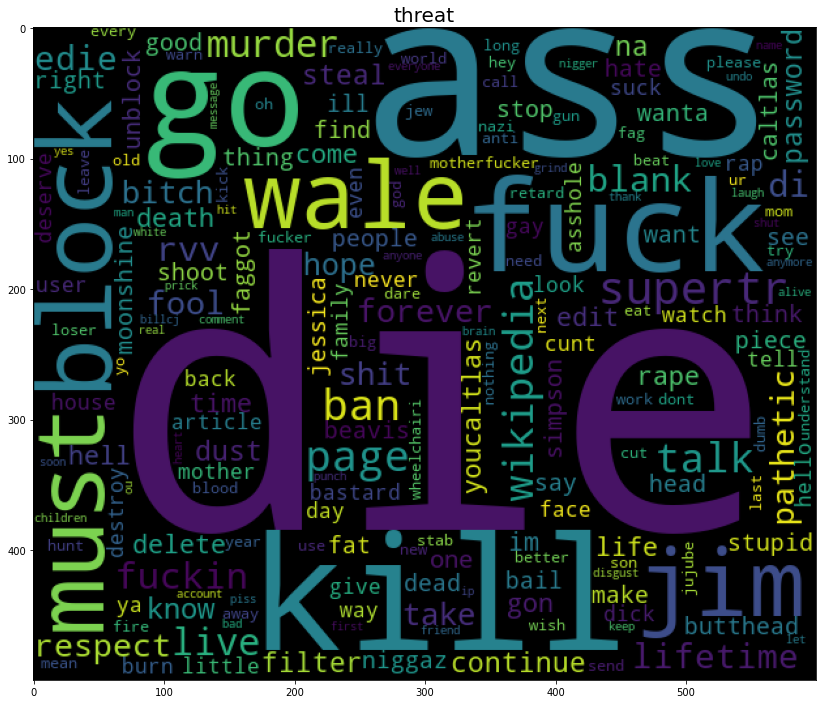

In [11]:
from wordcloud import WordCloud,STOPWORDS

def showWordCloud(df, label):
  plt.figure(figsize=(15,12))

  text = df[df[label]==1]["comment_text_clean"].tolist()
  label_img = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=600,
                          height=500,
                         ).generate(" ".join(text))

  plt.title(label,fontsize=20)
  plt.imshow(label_img)
showWordCloud(train_data, "threat")

### Determining the length of every comment and plotting for all classes




In [12]:
def length_of_comment(text):
  word_list = [item for item in text]
  return len(word_list)
train_data['length_of_comment'] = train_data['comment_text_clean'].apply(length_of_comment)
df_toxic = train_data.loc[train_data['toxic'] == 1]
df_severe_toxic = train_data.loc[train_data['severe_toxic'] == 1]
df_obscene = train_data.loc[train_data['obscene'] == 1]
df_threat = train_data.loc[train_data['threat'] == 1]
df_insult = train_data.loc[train_data['insult'] == 1]
df_identity_hate = train_data.loc[train_data['identity_hate'] == 1]

In [13]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Histogram(x=df_toxic.length_of_comment, name='toxic'))
fig.add_trace(go.Histogram(x=df_severe_toxic.length_of_comment, name='severe_toxic'))
fig.add_trace(go.Histogram(x=df_obscene.length_of_comment, name='obscene'))
fig.add_trace(go.Histogram(x=df_threat.length_of_comment, name='threat'))
fig.add_trace(go.Histogram(x=df_insult.length_of_comment, name='insult'))
fig.add_trace(go.Histogram(x=df_identity_hate.length_of_comment, name='identity hate'))


# Overlay both histograms
fig.update_layout(barmode = 'overlay')
# Reduce opacity to see both histograms
fig.update_traces(opacity=0.5)
fig.show()

### Determining the correlation between the classes and length of comment

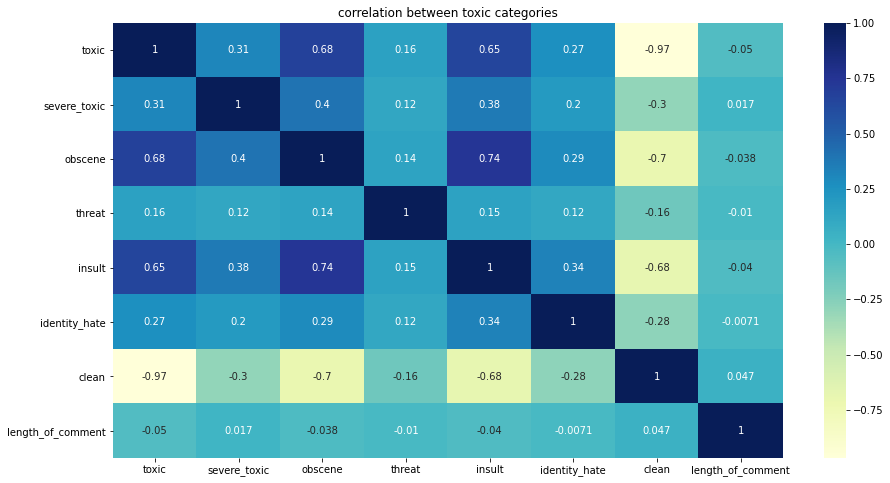

In [14]:
def corr_between_labels(df):
    plt.figure(figsize=(15,8))
    plt.title("correlation between toxic categories")
    sns.heatmap(df.corr(),cmap='YlGnBu',annot=True)
    plt.show()
    return 
corr_between_labels(train_data)

## Feature Engineering

### Dividing the dataset into train and test data

In [15]:
X_train = train_data['comment_text_clean']
Y_train = train_data[train_data.columns[2:8]]
X_test = test_data['comment_text_clean']
#X_train, X_test, y_train, y_test = train_test_split(X_train, Y_train, test_size=0.33, random_state=42)

### Applying the TF-IDF Vectorizer for converting words into vectors

In [16]:
# Instantiate the vectorizer
word_vectorizer = TfidfVectorizer(max_df=0.5,stop_words='english')

# fit and transform on it the training features
X_train_word_features = word_vectorizer.fit_transform(X_train)

#transform the test features to sparse matrix
test_features = word_vectorizer.transform(X_test)

## Applying Logistic Regression model to the obtained train data and noting the performance metrics (accuracy, precision and recall)

The Multi-label algorithm accepts a binary mask over multiple labels. The result for each prediction will be an array of 0s and 1s marking which class labels apply to each row input sample.

In [18]:
losses = []
auc = []
classes = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']
for label in classes:
    #call the labels one column at a time so we can run the classifier on them
    train_target = Y_train[label]
    test_target = test_labels[label]
    classifier = LogisticRegression(solver='sag', C=10)

    

    cv_score = np.mean(cross_val_score(classifier, X_train_word_features, train_target, cv=5, scoring='accuracy'))
    print('CV Accuracy score for class {} is {}'.format(label, cv_score))
    
    classifier.fit(X_train_word_features, train_target)
    y_pred = classifier.predict(test_features)
    y_pred_prob = classifier.predict_proba(test_features)[:, 1]
    submission_data[label] = y_pred_prob
    #fpr, tpr, threshold = metrics.roc_curve(test_target, y_pred_prob)
    #roc_auc = metrics.auc(fpr, tpr)

    #import matplotlib.pyplot as plt
    #plt.title('Receiver Operating Characteristic')
    #plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    #plt.legend(loc = 'lower right')
    #plt.plot([0, 1], [0, 1],'r--')
    #plt.xlim([0, 1])
    #plt.ylim([0, 1])
    #plt.ylabel('True Positive Rate')
    #plt.xlabel('False Positive Rate')
    #plt.show()

    print(confusion_matrix(test_target, y_pred))
    print(classification_report(test_target, y_pred))

CV Accuracy score for class toxic is 0.9587644341952171
[[    0 67623 21563]
 [    0 54554  3334]
 [    0  1401  4689]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     89186
           0       0.44      0.94      0.60     57888
           1       0.16      0.77      0.26      6090

    accuracy                           0.39    153164
   macro avg       0.20      0.57      0.29    153164
weighted avg       0.17      0.39      0.24    153164



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



CV Accuracy score for class severe_toxic is 0.9902175226502455
[[    0 88030  1156]
 [    0 63388   223]
 [    0   223   144]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     89186
           0       0.42      1.00      0.59     63611
           1       0.09      0.39      0.15       367

    accuracy                           0.41    153164
   macro avg       0.17      0.46      0.25    153164
weighted avg       0.17      0.41      0.24    153164



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



CV Accuracy score for class obscene is 0.9788432758408738
[[    0 76536 12650]
 [    0 59201  1086]
 [    0  1190  2501]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     89186
           0       0.43      0.98      0.60     60287
           1       0.15      0.68      0.25      3691

    accuracy                           0.40    153164
   macro avg       0.20      0.55      0.28    153164
weighted avg       0.17      0.40      0.24    153164



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



CV Accuracy score for class threat is 0.9971674065968317
[[    0 88979   207]
 [    0 63687    80]
 [    0   156    55]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     89186
           0       0.42      1.00      0.59     63767
           1       0.16      0.26      0.20       211

    accuracy                           0.42    153164
   macro avg       0.19      0.42      0.26    153164
weighted avg       0.17      0.42      0.25    153164



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



CV Accuracy score for class insult is 0.9701825557721705
[[    0 80121  9065]
 [    0 59660   891]
 [    0  1551  1876]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     89186
           0       0.42      0.99      0.59     60551
           1       0.16      0.55      0.25      3427

    accuracy                           0.40    153164
   macro avg       0.19      0.51      0.28    153164
weighted avg       0.17      0.40      0.24    153164



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



CV Accuracy score for class identity_hate is 0.9920536920806409
[[    0 88199   987]
 [    0 63125   141]
 [    0   492   220]]
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     89186
           0       0.42      1.00      0.59     63266
           1       0.16      0.31      0.21       712

    accuracy                           0.41    153164
   macro avg       0.19      0.44      0.27    153164
weighted avg       0.17      0.41      0.24    153164



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [19]:
submission_data.to_csv("submission.csv",index=False)